# Fetal Health Classification


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Import the dataset:

In [ ]:
data = pd.read_csv('fetal_health.csv')

In [ ]:
data.shape

(2126, 22)

The dataset contains 22 features and 2126 samples.

Let's analyze the variables at hand, their types and their distributions.

In [ ]:
data.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

Variables:

| Variable Name | Description |
| -------- | ------- |
| baseline value | Baseline Fetal Heart Rate (FHR) |                          
| accelerations | Number of accelerations per second |                                             
| fetal_movement | Number of fetal movements per second |                                              
| uterine_contractions | Number of uterine contractions per second |                                       
| light_decelerations | Number of LDs per second |                                        
| severe_decelerations | Number of SDs per second |                                       
| prolongued_decelerations | Number of PDs per second |                                   
| abnormal_short_term_variability | Percentage of time with abnormal short term variability |                            
| mean_value_of_short_term_variability | Mean value of short term variability |                       
| percentage_of_time_with_abnormal_long_term_variability | Percentage of time with abnormal long term variability |     
| mean_value_of_long_term_variability | Mean value of long term variability |                        
| histogram_width | Width of the histogram made using all values from a record |                                            
| histogram_min | Histogram minimum value |                                              
| histogram_max | Histogram maximum value |                                              
| histogram_number_of_peaks | Number of peaks in the exam histogram |                                  
| histogram_number_of_zeroes | Number of zeroes in the exam histogram |                                 
| histogram_mode | Histogram mode |                                             
| histogram_mean | Histogram mean |                                             
| histogram_median | Histogram median |                                           
| histogram_variance | Histogram variance |                                         
| histogram_tendency | Histogram trend:  \-1 = Downward, 0 = Steady, 1 = Upward|                                         
| fetal_health | Fetal health: 1 = Normal, 2 = Suspect, 3 = Pathological |   



The fetal_health variable, which is our target variable, is a float one. I discretize it in a categorical variable (we already know the mapping) to then perform classification.

In [ ]:
fetal_health_values = {'1.0': 'Normal',
                '2.0': 'Suspect',
                '3.0': 'Pathological'}

data['fetal_health'] = data['fetal_health'].astype(str).replace(fetal_health_values)

I use the *sweetviz* library to quickly obtain summary statistics on the variables and on their correlation.

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz

In [ ]:
my_report = sweetviz.analyze(data)
my_report.show_notebook()

Output hidden; open in https://colab.research.google.com to view.

There are no missing values, therefore we don't need to deal with filling them.

The dataset is quite imbalanced, with 78% of samples as Normal, 14% Suspect and just 8% Pathological.

Looking at each variable distribution, there are no samples that are outliers for a single variables. Let's analyze if there are any analyzing a more comprehensive overview, using isolation forest.

In [ ]:
from sklearn.ensemble import IsolationForest

data['outlier'] = IsolationForest(random_state=0).fit_predict(data)

print('There are {} outliers.'.format(data.loc[data.outlier==-1].shape[0]))

There are 273 outliers.


Let's see if these outliers are also our Pathological samples.

In [ ]:
print('OUTLIERS')
data.loc[data.outlier==-1]['fetal_health'].value_counts()

OUTLIERS


Pathological    120
Normal          116
Suspect          37
Name: fetal_health, dtype: int64

In [ ]:
print('INLIERS')
data.loc[data.outlier==1]['fetal_health'].value_counts()

INLIERS


Normal          1539
Suspect          258
Pathological      56
Name: fetal_health, dtype: int64

This is not the case given that outliers have mixed categories, as well as the inliers. Nevertheless, most of the pathological case result to be outliers, suggesting that pathological cases show more uncommon values recorded, the opposite happens for Normal samples.

Therefore, we keep all samples.

Based on the correlation analysis performed above, *histogram_mean*, *histogram_mode* and *histogram_median* are highly correlated. This might impact the upcoming classification task depending on the model we use.

In order to perform classification and choose the best model we need to split the dataset for training and testing in order to be able to then evaluate the performances of each model. In doing this, we shuffle the data and do a stratified sampling to keep the proportion of the classes both in the training and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,data.columns != 'fetal_health'], data['fetal_health'], test_size=0.2, shuffle=True, stratify=data['fetal_health'])

Let's start with a **decision tree**, which is not sensitive to multicollinearity, therefore we can keep all features.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

[Text(0.5, 11.049999999999999, 'True Label'),
 Text(38.24999999999999, 0.5, 'Predicted Label')]

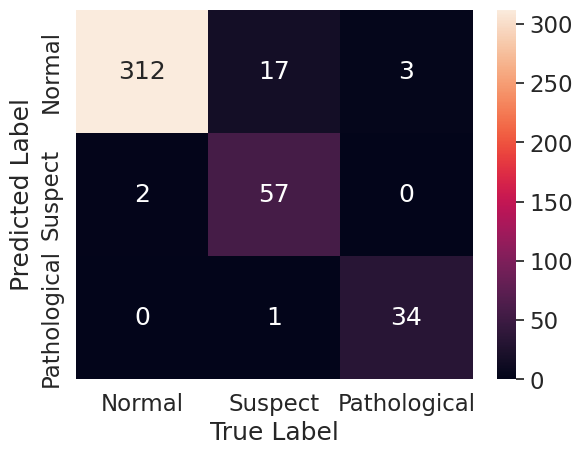

In [ ]:
from sklearn import metrics

y_predicted = clf.predict(X_test)

sns.set(font_scale=1.5)
g = sns.heatmap(metrics.confusion_matrix(y_test, y_predicted, labels=['Normal', 'Suspect', 'Pathological']), annot=True, fmt='.0f', xticklabels=['Normal', 'Suspect', 'Pathological'], yticklabels=['Normal', 'Suspect', 'Pathological'])
g.set(xlabel='True Label', ylabel='Predicted Label')

We compute macro metrics besides the confusion model to understand the overall performance.

In [ ]:
decisionTree_precision = metrics.precision_score(y_test, y_predicted, average='micro')
decisionTree_recall = metrics.recall_score(y_test, y_predicted, average='micro')
decisionTree_f1 = metrics.f1_score(y_test, y_predicted, average='micro')

print('Precision: {0:.2f}'.format(decisionTree_precision, '.2f'))
print('Recall: {0:.2f}'.format(decisionTree_recall, '.2f'))
print('F1-score: {0:.2f}'.format(decisionTree_f1, '.2f'))

Precision: 0.90
Recall: 0.90
F1-score: 0.90


Let's improve the model using a Random Forest Classifier.

[Text(0.5, 11.049999999999999, 'True Label'),
 Text(38.24999999999999, 0.5, 'Predicted Label')]

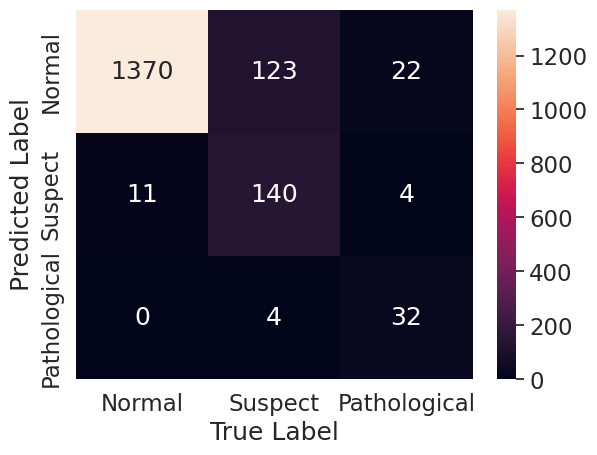

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

sns.set(font_scale=1.5)
g = sns.heatmap(metrics.confusion_matrix(y_test, y_predicted, labels=['Normal', 'Suspect', 'Pathological']), annot=True, fmt='.0f', xticklabels=['Normal', 'Suspect', 'Pathological'], yticklabels=['Normal', 'Suspect', 'Pathological'])
g.set(xlabel='True Label', ylabel='Predicted Label')

In [ ]:
RandomForest_precision = metrics.precision_score(y_test, y_predicted, average='micro')
RandomForest_recall = metrics.recall_score(y_test, y_predicted, average='micro')
RandomForest_f1 = metrics.f1_score(y_test, y_predicted, average='micro')

print('Precision: {0:.2f}'.format(RandomForest_precision, '.2f'))
print('Recall: {0:.2f}'.format(RandomForest_recall, '.2f'))
print('F1-score: {0:.2f}'.format(RandomForest_f1, '.2f'))

Precision: 0.94
Recall: 0.94
F1-score: 0.94


From the confusion matrix we can see that a few more samples are correctly classified as Normal or Suspect, still the classification of Pathological cases is not improved.

Finally, let's try with Logistic Regression.

First, let's apply dimensionality reduction given that we previously noticed there is multicollinealirty in the features.

[Text(0.5, 11.049999999999999, 'True Label'),
 Text(38.24999999999999, 0.5, 'Predicted Label')]

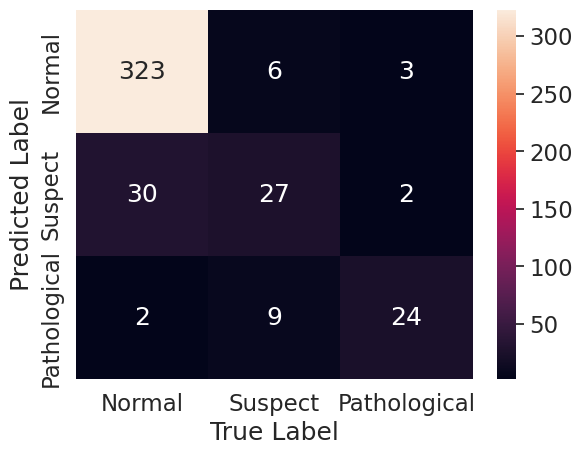

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2')
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

sns.set(font_scale=1.5)
g = sns.heatmap(metrics.confusion_matrix(y_test, y_predicted, labels=['Normal', 'Suspect', 'Pathological']), annot=True, fmt='.0f', xticklabels=['Normal', 'Suspect', 'Pathological'], yticklabels=['Normal', 'Suspect', 'Pathological'])
g.set(xlabel='True Label', ylabel='Predicted Label')

In [ ]:
LogisticRegression_precision = metrics.precision_score(y_test, y_predicted, average='micro')
LogisticRegression_recall = metrics.recall_score(y_test, y_predicted, average='micro')
LogisticRegression_f1 = metrics.f1_score(y_test, y_predicted, average='micro')

print('Precision: {0:.2f}'.format(LogisticRegression_precision, '.2f'))
print('Recall: {0:.2f}'.format(LogisticRegression_recall, '.2f'))
print('F1-score: {0:.2f}'.format(LogisticRegression_f1, '.2f'))

Precision: 0.86
Recall: 0.86
F1-score: 0.86


Therefore the best model is the Random Forest Classifier. Let's see if training with a balanced set can improve the performance. In fact, in some cases the model learn only from the most represented class (in this case, the Normal one).

In [ ]:
train_size = int(data['fetal_health'].value_counts()['Pathological']*0.8)

data = data.sample(frac=1).reset_index(drop=True)

train = pd.concat([data.loc[data['fetal_health'] == 'Normal'].reset_index(drop=True).iloc[:train_size],
                   data.loc[data['fetal_health'] == 'Suspect'].reset_index(drop=True).iloc[:train_size],
                   data.loc[data['fetal_health'] == 'Pathological'].reset_index(drop=True).iloc[:train_size]])

test = pd.concat([data.loc[data['fetal_health'] == 'Normal'].reset_index(drop=True).iloc[train_size:],
                   data.loc[data['fetal_health'] == 'Suspect'].reset_index(drop=True).iloc[train_size:],
                   data.loc[data['fetal_health'] == 'Pathological'].reset_index(drop=True).iloc[train_size:]])



X_train = train.loc[:,train.columns != 'fetal_health']
y_train = train['fetal_health']
X_test = test.loc[:,test.columns != 'fetal_health']
y_test = test['fetal_health']

[Text(0.5, 11.049999999999999, 'True Label'),
 Text(38.24999999999999, 0.5, 'Predicted Label')]

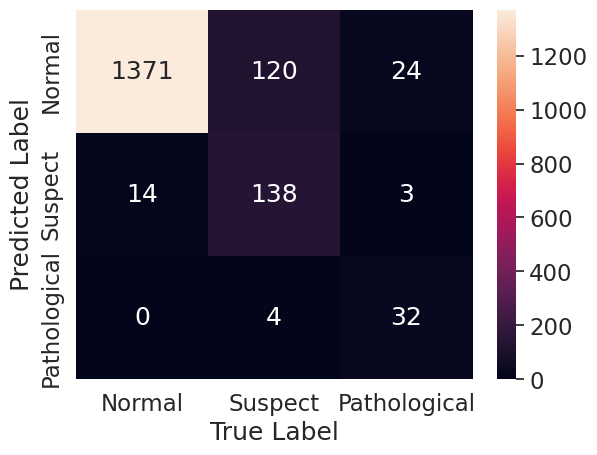

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

sns.set(font_scale=1.5)
g = sns.heatmap(metrics.confusion_matrix(y_test, y_predicted, labels=['Normal', 'Suspect', 'Pathological']), annot=True, fmt='.0f', xticklabels=['Normal', 'Suspect', 'Pathological'], yticklabels=['Normal', 'Suspect', 'Pathological'])
g.set(xlabel='True Label', ylabel='Predicted Label')

In [ ]:
RandomForest_precision = metrics.precision_score(y_test, y_predicted, average='micro')
RandomForest_recall = metrics.recall_score(y_test, y_predicted, average='micro')
RandomForest_f1 = metrics.f1_score(y_test, y_predicted, average='micro')

print('Precision: {0:.2f}'.format(RandomForest_precision, '.2f'))
print('Recall: {0:.2f}'.format(RandomForest_recall, '.2f'))
print('F1-score: {0:.2f}'.format(RandomForest_f1, '.2f'))

Precision: 0.90
Recall: 0.90
F1-score: 0.90


This change does not improve the ability of the model of classifying Pathological cases.

As a final step, we study the importance of features to give more explainaility of the model.

In [ ]:
! pip install shap

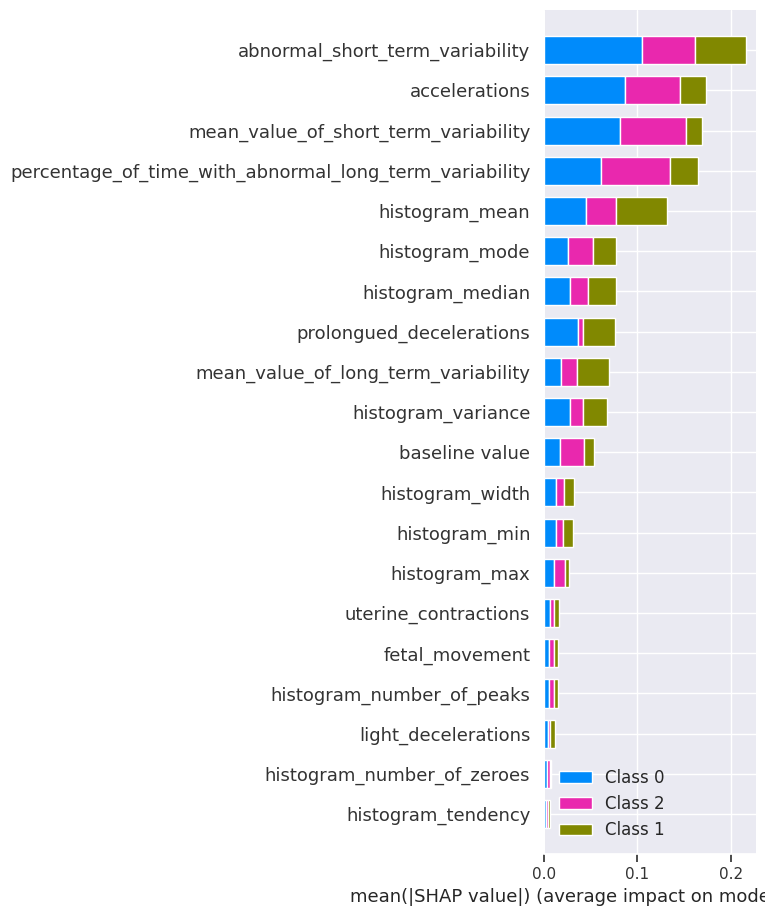

In [ ]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

The top 5 feature seem to be the most impactiful in the general prediction, given the small cut-off from the sixth down. Nevertheless, for a specific class (1) the features in the middle are more important for the classification task.